This notebook demonstrates how to compute the auto power spectra and the cross power spectra for cosmic fields. Here, we use the CMB lensing signal and the CIB temperature.

In [47]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as scc

from quickspec.cib import hall
from quickspec import cosmo, mps, lens

In [3]:
plt.style.use('ggplot')

# Cosmology

We begin by defining the initial conditions and the cosmology.

In [4]:
initial_cond = mps.mps.initial_ps()

In [5]:
mycosmo = cosmo.LCDM()

In [6]:
vars(mycosmo).keys()

dict_keys(['_spl_x_z', '_spl_z_x', 'omr', 'omb', 'omc', 'oml', 'H0', 'h', 'omm', 'zvec', 'xvec', 'zmin', 'zmax', 'xmin', 'xmax'])

# Matter power spectrum

In [7]:
mymps = mps.lin.mps_camb(
    cosmo=mycosmo, sips=initial_cond, nonlinear=True)

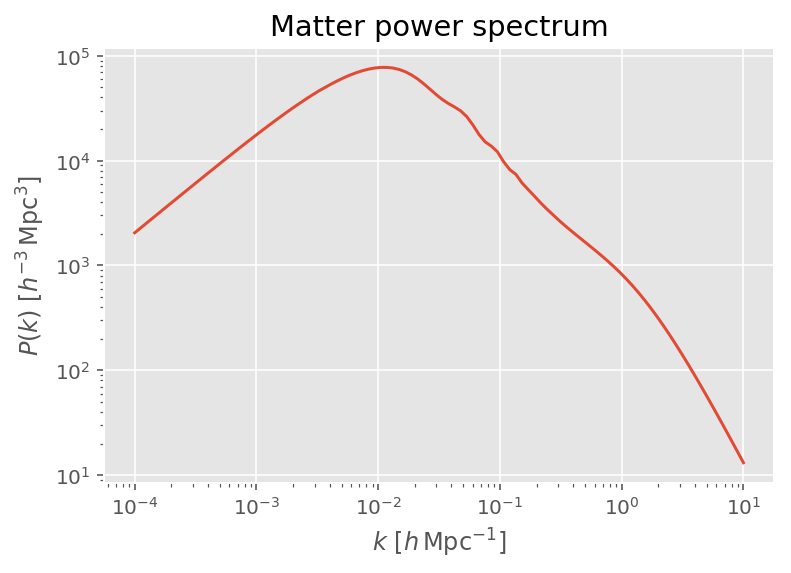

In [8]:
kk = np.logspace(-4, 1, 100)

plt.plot(kk, mymps.p_kz(kk, z=0))
plt.loglog()

# labels & legends
plt.title('Matter power spectrum')
plt.xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')
plt.ylabel(r'$P(k)\ [h^{-3}\,\rm Mpc^3]$');

# Kernels

In [9]:
ls = np.arange(10, 2048., 20)

The lensing kernel used here depends only on `quickspec.cosmo`.

In [10]:
kernel_lens = lens.kern(mycosmo)

For the CIB kernel, we need the FIR frequency at which we want to evaluate the power spectrum and the parameters for the Hall+ (2010) model.

In [11]:
nu = 545.e9
zc = 2.
sigmaz = 2.
b = 0.8 / np.sqrt(2.4)

kernel_cib = hall.ssed_kern(
    nu,
    jbar_kwargs={'zc': zc, 'sigmaz': sigmaz},
    b0=b,
    b1=0.1,
    b2=0.1,
    fnl=0.001,
    mps=mymps)

# Inspect power spectra

In [27]:
fnls = np.logspace(-3, 2, 6)
fnls

array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02])

In [28]:
nu = 545.e9
zc = 2.
sigmaz = 2.
b = 0.8 / np.sqrt(2.4)

def fnl2crosspower(fnl):
    kernel_cib = hall.ssed_kern(
        nu,
        jbar_kwargs={'zc': zc, 'sigmaz': sigmaz},
        b0=b,
        fnl=fnl,
        mps=mymps)
    
    powspec_TP = mymps.cl_limber_z(
        kernel_cib, kernel_lens,
        ls=ls, zmin=1.e-2, zmax=20.)
    
    return powspec_TP

powerspectra = np.array(list(map(fnl2crosspower, fnls)))

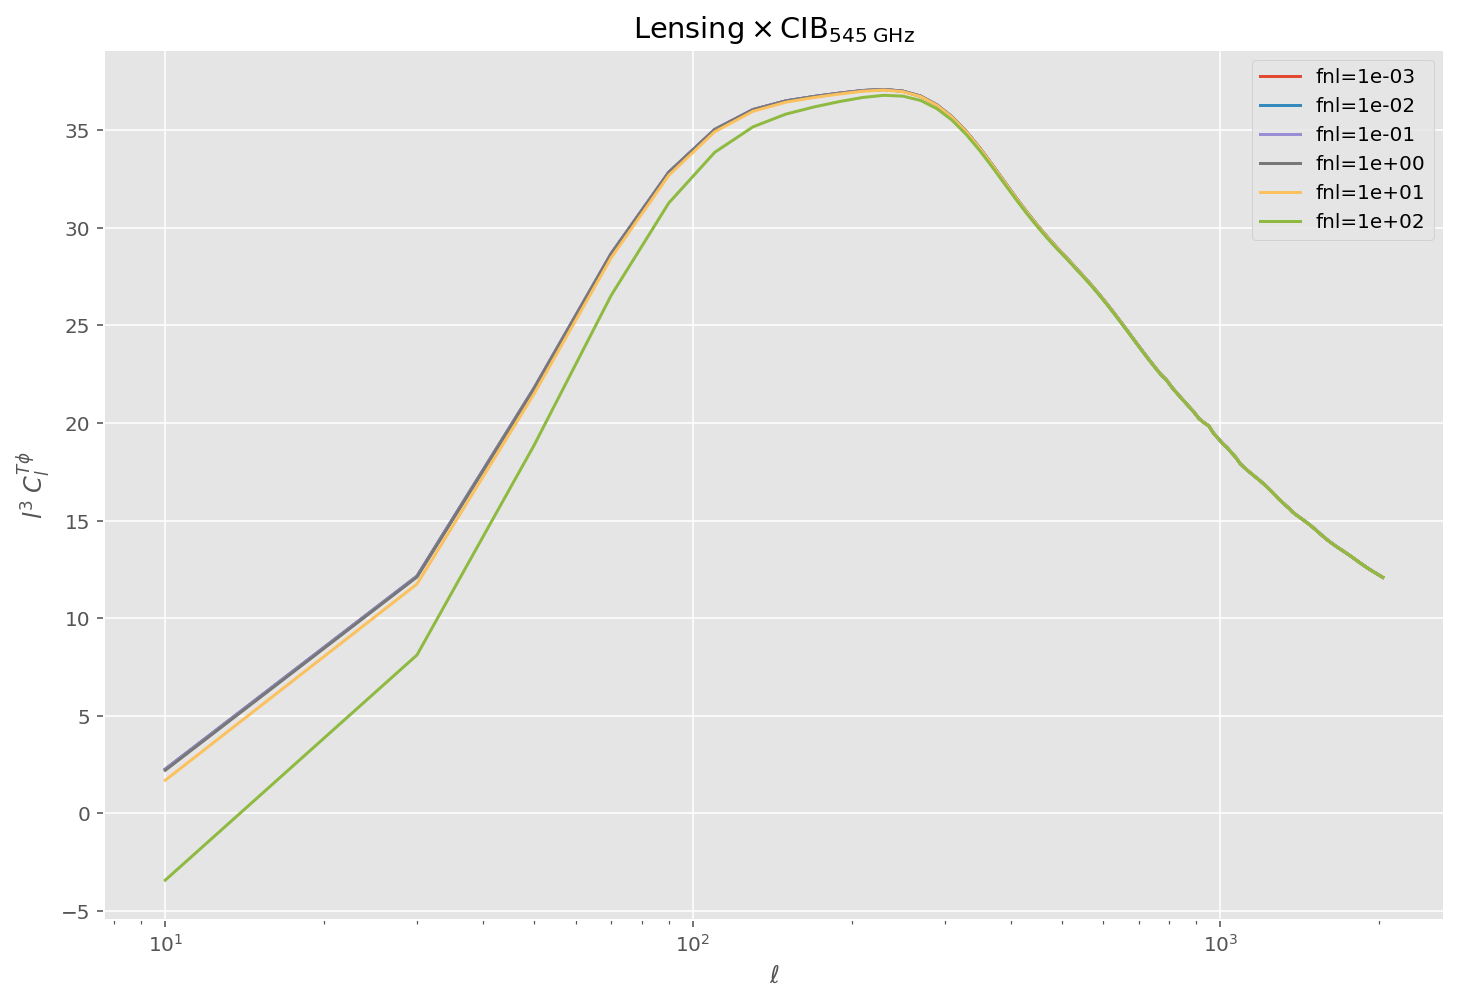

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

for powspec, fnl in zip(powerspectra, fnls):
    ax.plot(ls, ls**3 * powspec, label=f'fnl={fnl:.0e}')
    ax.semilogx()
    
    # Labels & legend
    ax.legend()
    ax.set_title(r'$\rm Lensing \times CIB_{545\;GHz}$')
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$l^3\; C_l^{T\phi}$')

plt.savefig('/users/dlenz/Downloads/Cl_CIBxPhi_fnls.pdf', dpi=300)
